In [1]:
import sys
sys.path.append("..")
from core.DataLoader import DataPreprocessor, DataConfig
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
MAX_JETS = 4
PLOTS_DIR = f"plots/"
import os
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)


2025-10-20 22:00:14.212919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 22:00:14.213894: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 22:00:14.217962: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 22:00:14.227245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760990414.242156 1387440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760990414.24

In [2]:
config = DataConfig(jet_features=["ordered_jet_pt","ordered_jet_eta", "ordered_jet_phi","ordered_jet_e","ordered_jet_b_tag","m_l2j","m_l1j","dR_l1j","dR_l2j"], 
                                lepton_features=["lep_pt", "lep_eta", "lep_phi", "lep_e", "lep_charge"],
                                jet_truth_label="ordered_event_jet_truth_idx", 
                                lepton_truth_label="event_lepton_truth_idx", 
                                global_features = ["met_met_NOSYS","met_phi_NOSYS"], 
                                max_leptons=2, 
                                max_jets = MAX_JETS, 
                                non_training_features =["truth_ttbar_mass", "truth_ttbar_pt", "N_jets", "dR_l1l2","Ttbar_MC_t_afterFSR_m","Ttbar_MC_tbar_afterFSR_m","Ttbar_MC_W_afterFSR_from_t_m","Ttbar_MC_W_afterFSR_from_tbar_m"], 
                                event_weight="weight_mc_NOSYS")

DataProcessor = DataPreprocessor(config)


DataProcessor.load_data("/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events = 100000)
#DataProcessor.plot_feature_correlation()

jet_b_tag = DataProcessor.get_feature_data("jet", "ordered_jet_b_tag")
jet_pt = DataProcessor.get_feature_data("jet", "ordered_jet_pt")
jet_dR_lep_jet = np.stack([DataProcessor.get_feature_data("jet", "dR_l1j"), DataProcessor.get_feature_data("jet", "dR_l2j")],axis = -1)
#jet_dR = DataProcessor.get_feature_data("jet", "dR_lep_jet")
lep_pt = DataProcessor.get_feature_data("lepton", "lep_pt")
dR_l1l2 = DataProcessor.get_feature_data("non_training", "dR_l1l2")
lep_e = DataProcessor.get_feature_data("lepton", "lep_e")
lep_eta = DataProcessor.get_feature_data("lepton", "lep_eta")
lep_phi = DataProcessor.get_feature_data("lepton", "lep_phi")
lep_charge = DataProcessor.get_feature_data("lepton", "lep_charge")

ttbar_mass = DataProcessor.get_feature_data("non_training", "truth_ttbar_mass")
ttbar_pt = DataProcessor.get_feature_data("non_training", "truth_ttbar_pt")
W_mass_from_t = DataProcessor.get_feature_data("non_training", "Ttbar_MC_W_afterFSR_from_t_m")
W_mass_from_tbar = DataProcessor.get_feature_data("non_training", "Ttbar_MC_W_afterFSR_from_tbar_m")

N_jets = DataProcessor.get_feature_data("non_training", "N_jets")
mc_weight = DataProcessor.get_feature_data("event_weight", "weight_mc_NOSYS")
top_mass = DataProcessor.get_feature_data("non_training", "Ttbar_MC_t_afterFSR_m")
tbar_mass = DataProcessor.get_feature_data("non_training", "Ttbar_MC_tbar_afterFSR_m")
mL_lep_jet = np.stack([DataProcessor.get_feature_data("jet", "m_l1j"), DataProcessor.get_feature_data("jet", "m_l2j")],axis = -1)
#mL_lep_jet = DataProcessor.get_feature_data("jet", "m_lep_jet")
truth_idx = DataProcessor.get_labels()
b_tag_indices = np.empty((jet_b_tag.shape[0], 2), dtype = int)

In [3]:

def dR_jet_matcher(jet_b_tag, jet_dR, jet_pt):
    jet_matcher_indices = np.empty((jet_b_tag.shape[0], 2), dtype = int)
    for i in range(len(jet_b_tag)):
        valid_indices = np.where(jet_b_tag[i] != -999)[0]
        b_tag_indices = []
        if len(valid_indices) < 2:
            continue
        if np.sum(jet_b_tag[i, valid_indices] > 2) >= 2:
            b_tag_indices = valid_indices[np.where(jet_b_tag[i, valid_indices] > 2)[0]]
        elif np.sum(jet_b_tag[i, valid_indices] > 2) == 1:
            b_tag_indices.append(valid_indices[np.argsort(jet_b_tag[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.where(jet_b_tag[i, valid_indices] <= 2)[0][0]])
        else:
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-2]])
        # Find the (jet, lepton) pair with the smallest dR
        dR_sub = jet_dR[i, valid_indices, :]
        jet_idx, lep_idx = np.unravel_index(np.argmin(dR_sub), dR_sub.shape)
        first_jet = valid_indices[jet_idx]
        jet_matcher_indices[i][lep_idx] = first_jet

        # Remove the assigned jet from valid_indices and assign the remaining lepton to the next best jet
        remaining_lep = 1 - lep_idx
        remaining_jets = np.delete(valid_indices, jet_idx)
        next_jet_idx = remaining_jets[np.argmin(jet_dR[i, remaining_jets, remaining_lep])]
        jet_matcher_indices[i][remaining_lep] = next_jet_idx
    return jet_matcher_indices

def non_exclusive_dR_jet_matcher(jet_b_tag, jet_dR, jet_pt):
    jet_matcher_indices = np.empty((jet_b_tag.shape[0], 2), dtype = int)
    for i in range(len(jet_b_tag)):
        valid_indices = np.where(jet_b_tag[i] != -999)[0]
        b_tag_indices = []
        if len(valid_indices) < 2:
            continue
        if np.sum(jet_b_tag[i, valid_indices] > 2) >= 2:
            b_tag_indices = valid_indices[np.where(jet_b_tag[i, valid_indices] > 2)[0]]
        elif np.sum(jet_b_tag[i, valid_indices] > 2) == 1:
            b_tag_indices.append(valid_indices[np.argsort(jet_b_tag[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.where(jet_b_tag[i, valid_indices] <= 2)[0][0]])
        else:
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-2]])
        # Find the (jet, lepton) pair with the smallest dR
        dR_sub = jet_dR[i, valid_indices, :]
        jet_matcher_indices[i, 0] = valid_indices[np.argmin(dR_sub[:, 0])]
        jet_matcher_indices[i, 1] = valid_indices[np.argmin(dR_sub[:, 1])]
    return jet_matcher_indices

def mL_jet_matcher(jet_b_tag, jet_dR, jet_pt):
    jet_matcher_indices = np.empty((jet_b_tag.shape[0], 2), dtype = int)
    for i in range(len(jet_b_tag)):
        valid_indices = np.where(jet_b_tag[i] != -999)[0]
        b_tag_indices = []
        if len(valid_indices) < 2:
            continue
        if np.sum(jet_b_tag[i, valid_indices] > 2) >= 2:
            b_tag_indices = valid_indices[np.where(jet_b_tag[i, valid_indices] > 2)[0]]
        elif np.sum(jet_b_tag[i, valid_indices] > 2) == 1:
            b_tag_indices.append(valid_indices[np.argsort(jet_b_tag[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.where(jet_b_tag[i, valid_indices] <= 2)[0][0]])
        else:
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-2]])
        # Find the (jet, lepton) pair with the smallest dR
        dR_sub = jet_dR[i, valid_indices, :]
        jet_idx, lep_idx = np.unravel_index(np.argmax(dR_sub), dR_sub.shape)
        first_jet = valid_indices[jet_idx]
        jet_matcher_indices[i][lep_idx] = first_jet

        # Remove the assigned jet from valid_indices and assign the remaining lepton to the next best jet
        remaining_lep = 1 - lep_idx
        remaining_jets = np.delete(valid_indices, jet_idx)
        next_jet_idx = remaining_jets[np.argmax(jet_dR[i, remaining_jets, remaining_lep])]
        jet_matcher_indices[i][remaining_lep] = next_jet_idx
    return jet_matcher_indices

def non_exclusive_mL_jet_matcher(jet_b_tag, jet_dR, jet_pt):
    jet_matcher_indices = np.empty((jet_b_tag.shape[0], 2), dtype = int)
    for i in range(len(jet_b_tag)):
        valid_indices = np.where(jet_b_tag[i] != -999)[0]
        b_tag_indices = []
        if len(valid_indices) < 2:
            continue
        if np.sum(jet_b_tag[i, valid_indices] > 2) >= 2:
            b_tag_indices = valid_indices[np.where(jet_b_tag[i, valid_indices] > 2)[0]]
        elif np.sum(jet_b_tag[i, valid_indices] > 2) == 1:
            b_tag_indices.append(valid_indices[np.argsort(jet_b_tag[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.where(jet_b_tag[i, valid_indices] <= 2)[0][0]])
        else:
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-1]])
            b_tag_indices.append(valid_indices[np.argsort(jet_pt[i, valid_indices])[-2]])
        # Find the (jet, lepton) pair with the smallest dR
        dR_sub = jet_dR[i, valid_indices, :]
        jet_matcher_indices[i, 0] = valid_indices[np.argmax(dR_sub[:, 0])]
        jet_matcher_indices[i, 1] = valid_indices[np.argmax(dR_sub[:, 1])]
    return jet_matcher_indices

truth_index = np.argmax(truth_idx, axis = 1)
dR_matched_indices = dR_jet_matcher(jet_b_tag, mL_lep_jet, jet_pt)
ml_matched_indices = mL_jet_matcher(jet_b_tag, mL_lep_jet, jet_pt)



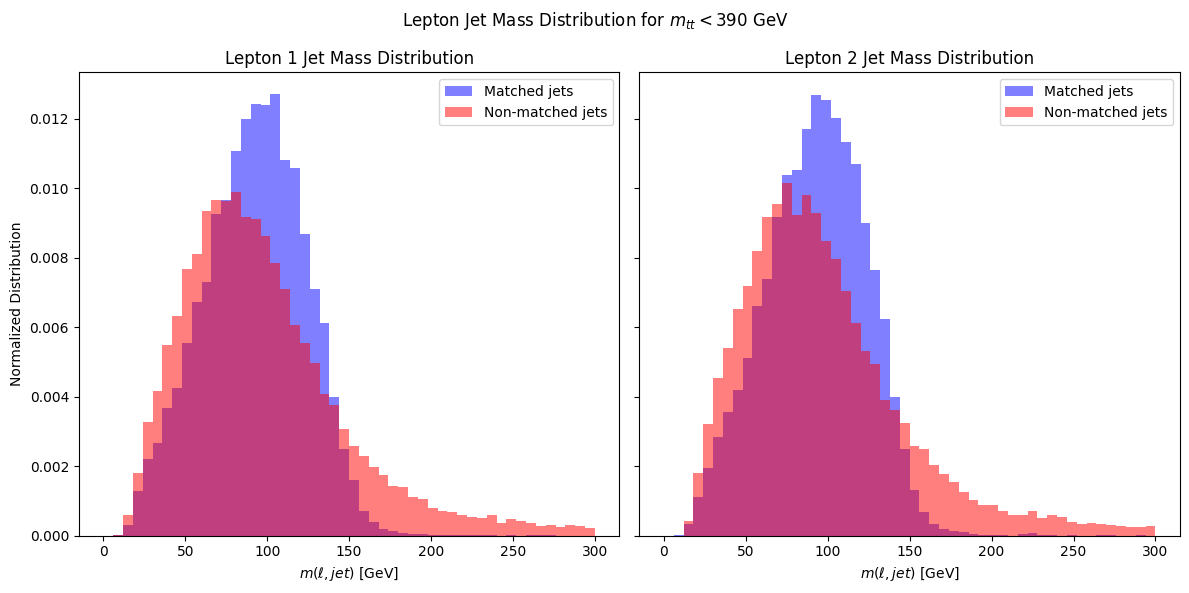

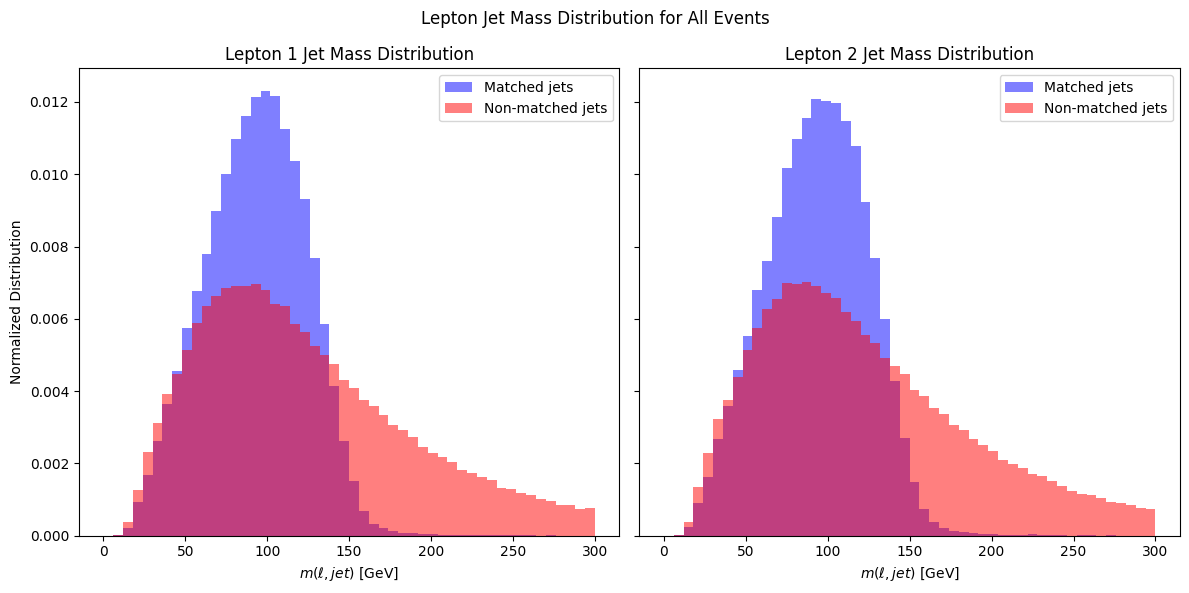

In [4]:
def plot_lepton_jet_distributions(mL_lep_jet, mc_weight, truth_index, fig = None, ax = None, rescale_factor = 1.0, bins = 20, xlim = None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    lep_1_truth_mL = mL_lep_jet[np.arange(0, config.max_jets).reshape(1, -1) == truth_index[:, 0].reshape((-1, 1)), 0]
    lep_1_false_mL = mL_lep_jet[np.arange(0, config.max_jets).reshape(1, -1) != truth_index[:, 0].reshape((-1, 1)), 0]
    lep_1_truth_weight = np.broadcast_to(mc_weight.reshape(-1, 1), (mL_lep_jet.shape[0], config.max_jets))[np.arange(0, config.max_jets).reshape(1, -1) == truth_index[:, 0].reshape((-1, 1))] / np.sum(mc_weight)
    lep_1_false_weight = np.broadcast_to(mc_weight.reshape(-1, 1), (mL_lep_jet.shape[0], config.max_jets))[np.arange(0, config.max_jets).reshape(1, -1) != truth_index[:, 0].reshape((-1, 1))] / np.sum(mc_weight)

    lep_2_truth_mL = mL_lep_jet[np.arange(0, config.max_jets).reshape(1, -1) == truth_index[:, 1].reshape((-1, 1)), 1]
    lep_2_false_mL = mL_lep_jet[np.arange(0, config.max_jets).reshape(1, -1) != truth_index[:, 1].reshape((-1, 1)), 1]
    lep_2_truth_weight = np.broadcast_to(mc_weight.reshape(-1, 1), (mL_lep_jet.shape[0], config.max_jets))[np.arange(0, config.max_jets).reshape(1, -1) == truth_index[:, 1].reshape((-1, 1))] / np.sum(mc_weight)
    lep_2_false_weight = np.broadcast_to(mc_weight.reshape(-1, 1), (mL_lep_jet.shape[0], config.max_jets))[np.arange(0, config.max_jets).reshape(1, -1) != truth_index[:, 1].reshape((-1, 1))] / np.sum(mc_weight)

    _, bins = np.histogram(mL_lep_jet[mL_lep_jet != -999] / rescale_factor, bins=bins, range=xlim)    

    ax[0].hist(lep_1_truth_mL / rescale_factor, bins=bins, alpha=0.5, label="Matched jets", color='blue', density=True, weights=lep_1_truth_weight)
    ax[0].hist(lep_1_false_mL[lep_1_false_mL != -999] / rescale_factor, bins=bins, alpha=0.5, label="Non-matched jets", color='red', density=True, weights=lep_1_false_weight[lep_1_false_mL != -999])
    ax[1].hist(lep_2_truth_mL / rescale_factor, bins=bins, alpha=0.5, label="Matched jets", color='blue', density=True, weights=lep_2_truth_weight)
    ax[1].hist(lep_2_false_mL[lep_2_false_mL != -999] / rescale_factor, bins=bins, alpha=0.5, label="Non-matched jets", color='red', density=True, weights=lep_2_false_weight[lep_2_false_mL != -999])

    return fig, ax

fig, ax = plot_lepton_jet_distributions(mL_lep_jet[ttbar_mass < 390e3], mc_weight[ttbar_mass < 390e3], truth_index[ttbar_mass < 390e3], rescale_factor=1e3, bins = 50, xlim=(0, 300))
ax[0].set_xlabel("$m(\ell,jet)$ [GeV]")
ax[1].set_xlabel("$m(\ell,jet)$ [GeV]")
ax[0].set_ylabel("Normalized Distribution")
ax[0].set_title("Lepton 1 Jet Mass Distribution")
ax[1].set_title("Lepton 2 Jet Mass Distribution")
ax[0].legend()
ax[1].legend()
fig.suptitle("Lepton Jet Mass Distribution for $m_{tt} < 390$ GeV")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "lepton_jet_mass_distribution_m_tt_390GeV.png")


fig, ax = plot_lepton_jet_distributions(mL_lep_jet, mc_weight, truth_index, rescale_factor=1e3, bins = 50, xlim=(0, 300))
ax[0].set_xlabel("$m(\ell,jet)$ [GeV]")
ax[1].set_xlabel("$m(\ell,jet)$ [GeV]")
ax[0].set_ylabel("Normalized Distribution")
ax[0].set_title("Lepton 1 Jet Mass Distribution")
ax[1].set_title("Lepton 2 Jet Mass Distribution")
ax[0].legend()
ax[1].legend()
fig.suptitle("Lepton Jet Mass Distribution for All Events")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "lepton_jet_mass_distribution.png")



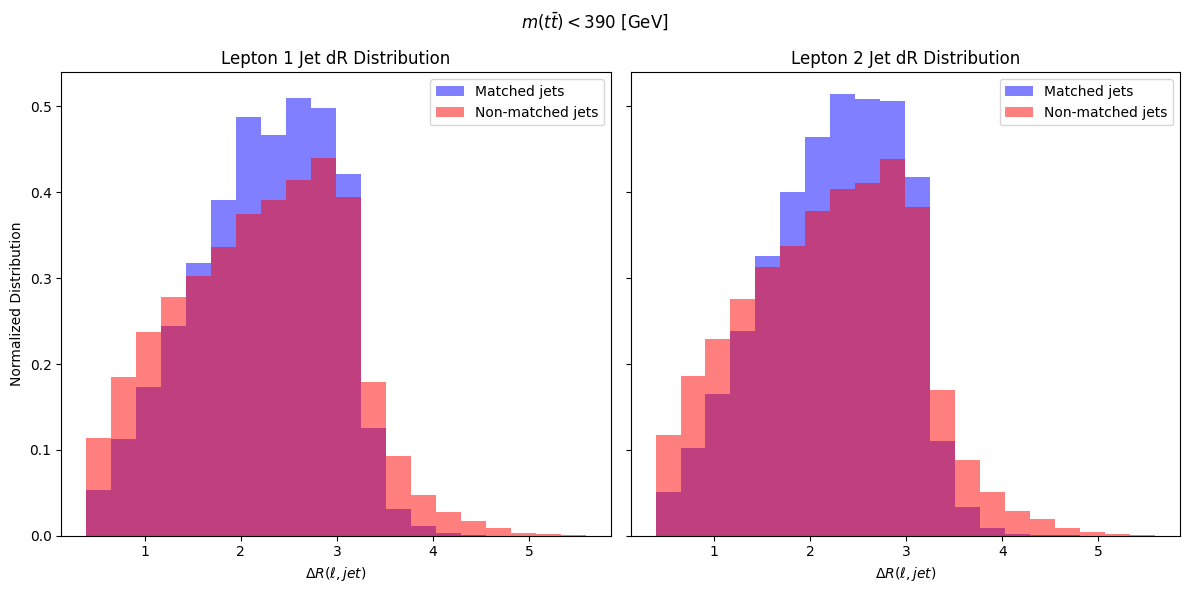

In [5]:
fig, ax = plot_lepton_jet_distributions(jet_dR_lep_jet[ttbar_mass < 390e3], mc_weight[ttbar_mass < 390e3], truth_index[ttbar_mass < 390e3])
ax[0].set_xlabel("$\Delta R(\ell,jet)$")
ax[1].set_xlabel("$\Delta R(\ell,jet)$")
ax[0].set_ylabel("Normalized Distribution")
ax[0].set_title("Lepton 1 Jet dR Distribution")
ax[1].set_title("Lepton 2 Jet dR Distribution")
ax[0].legend()
ax[1].legend()
fig.suptitle(r"$m(t\bar{t}) < 390$ [GeV]")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "lepton_jet_dR_distribution_m_tt_390Gev.png")

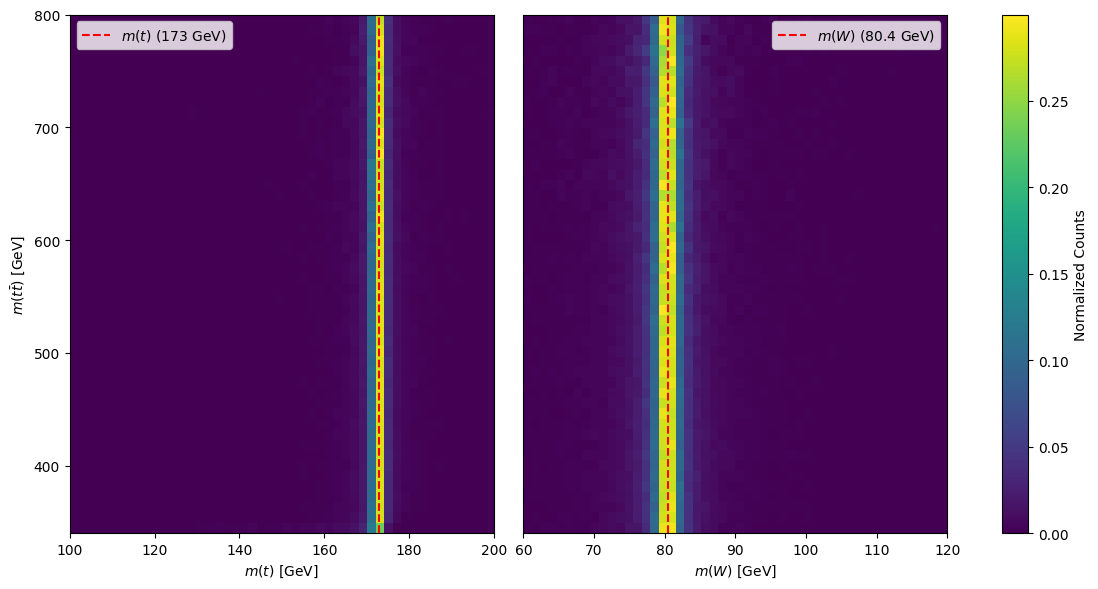

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
top_mass_hist_counts, ttbar_mass_edges, top_mass_edges = np.histogram2d(np.concatenate([ttbar_mass/1e3,ttbar_mass/1e3]), np.concatenate([top_mass/1e3, tbar_mass/1e3]), bins=(50, 50), range =[[ 340, 800],[100, 200]], weights=np.concatenate([mc_weight, mc_weight]) )
top_mass_hist_counts /= np.sum(top_mass_hist_counts, axis = 1).reshape(-1, 1)  # Normalize the histogram
im = ax[0].imshow(top_mass_hist_counts, origin='lower', aspect='auto', extent=(top_mass_edges[0], top_mass_edges[-1],ttbar_mass_edges[0], ttbar_mass_edges[-1]), cmap='viridis')
ax[0].set_xlabel(r"$m(t)$ [GeV]")
ax[0].set_ylabel(r"$m(t\bar{t})$ [GeV]")
ax[0].axvline(x=173.0, color='red', linestyle='--', label=r'$m(t)$ (173 GeV)')
W_mass_hist_counts, ttbar_mass_edges, W_mass_edges = np.histogram2d(np.concatenate([ttbar_mass/1e3,ttbar_mass/1e3]), np.concatenate([W_mass_from_t/1e3,W_mass_from_tbar/1e3]), bins=(50, 50), range =[[340, 800],[ 60, 120]], weights=np.concatenate([mc_weight, mc_weight]) )
W_mass_hist_counts /= np.sum(W_mass_hist_counts, axis = 1).reshape(-1, 1)  # Normalize the histogram
im = ax[1].imshow(W_mass_hist_counts, origin='lower', aspect='auto', extent=(W_mass_edges[0], W_mass_edges[-1],ttbar_mass_edges[0], ttbar_mass_edges[-1]), cmap='viridis')
ax[1].set_xlabel(r"$m(W)$ [GeV]")
ax[1].set_ylabel(None)
ax[1].set_yticks([])  # Remove y-ticks for the second plot
ax[1].axvline(x=80.4, color='red', linestyle='--', label=r'$m(W)$ (80.4 GeV)')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')

fig.tight_layout()
fig.colorbar(im, ax=ax, orientation='vertical', label='Normalized Counts')
plt.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_top_mass.png")

In [7]:
from core import DataPlotter
data_plotter = DataPlotter(DataProcessor, plots_dir=PLOTS_DIR)
data_plotter.plot_correlation_matrix()

/afs/desy.de/user/a/aulich/mva-trainer/venv/lib64/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/afs/desy.de/user/a/aulich/mva-trainer/venv/lib64/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Relational Jet-Lepton Feature Distribution'}, xlabel='Feature Value', ylabel='Frequency'>)

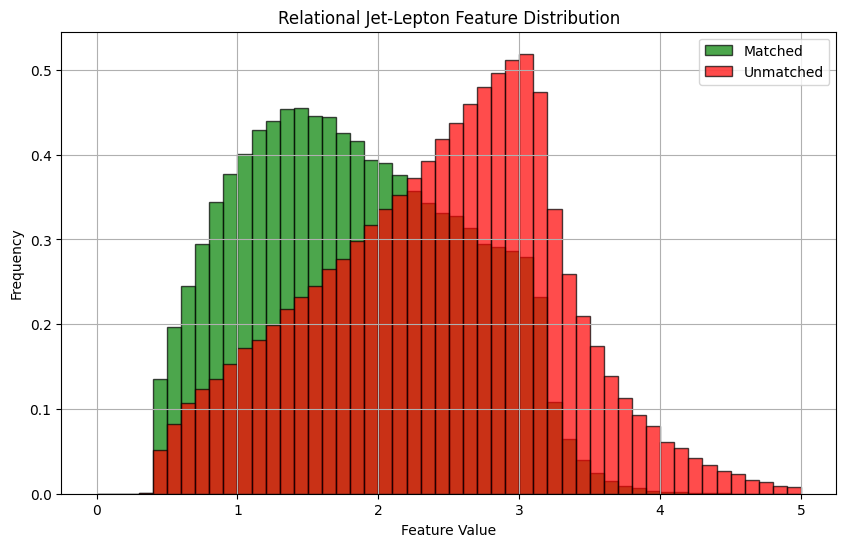

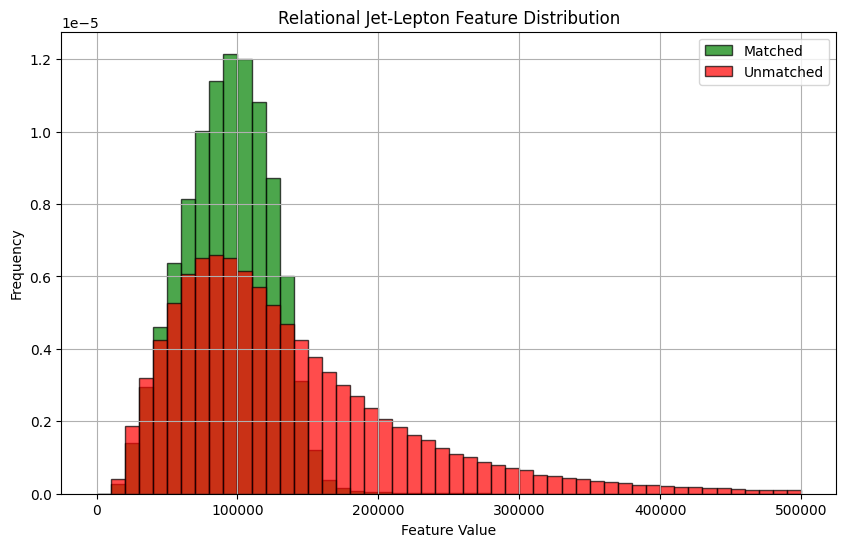

In [9]:
def delta_R(jet_features, lepton_features):
    delta_eta = jet_features[1] - lepton_features[1]
    delta_phi = jet_features[2] - lepton_features[2]
    delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def invariant_mass(jet_features, lepton_features):
    jet_e = jet_features[3]
    jet_px = jet_features[0] * np.cos(jet_features[2])
    jet_py = jet_features[0] * np.sin(jet_features[2])
    jet_pz = jet_features[0] * np.sinh(jet_features[1])

    lep_e = lepton_features[3]
    lep_px = lepton_features[0] * np.cos(lepton_features[2])
    lep_py = lepton_features[0] * np.sin(lepton_features[2])
    lep_pz = lepton_features[0] * np.sinh(lepton_features[1])

    total_e = jet_e + lep_e
    total_px = jet_px + lep_px
    total_py = jet_py + lep_py
    total_pz = jet_pz + lep_pz

    return np.sqrt(total_e**2 - total_px**2 - total_py**2 - total_pz**2)

data_plotter.plot_relational_jet_lepton_features(delta_R, "Delta_R", bins=50, range=(0, 5))
data_plotter.plot_relational_jet_lepton_features(invariant_mass, "Invariant_Mass", bins=50, range=(0, 500e3))